# __Classical forecasting methods__

Classical time series modelling is a well developed field, that offers models that are the best option for many problems.

Commonly these models rely on decomposition of the time series into it's components, and have stricter requirements (such as stationarity or no seasonality) than more general machine learning approaches.

## __Forecasting with the Holt-Winters method__

The Holt-Winters method takes the trend as well as seasonality of a time series into account. Note that it only considers time features (hour of day, month of year etc) and no exogenous features

In [1]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='../images/Holt_Winter_additive.png' width='400'></td><td><img src='../images/Holt_Winter_multiplicative.png'width='280'></td></tr></table>"))
display(HTML("<i>l<sub>t</sub></i>: level"))
display(HTML("<i>b<sub>t</sub></i>: trend"))
display(HTML("<i>s<sub>t</sub></i>: seasonal component"))

,


[Hyndman and Athanasopoulos, Forecasting: Principles and Practice](https://otexts.com/fpp2/)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings #ignore harmless warnings
warnings.simplefilter('ignore')

In [3]:
#set desired DateTimeIndex as index and parse dates leads to DateTimeIndex right away
df = pd.read_csv('../data/airline_passengers.csv', index_col=0, parse_dates=True)

#resample DateTimeIndex as to beginning of each month
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
print(df.index.min())
print(df.index.max())

1949-01-01 00:00:00
1960-12-01 00:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
Thousands of Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [6]:
#the .describe method provides a good overview over the most basic statistics of the feature columns of a dataset
df.describe()

,Thousands of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


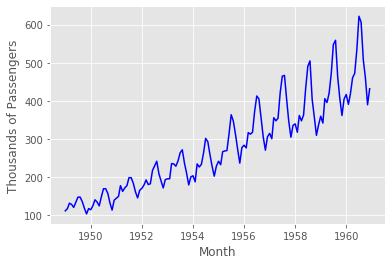

In [7]:
plt.style.use('ggplot')

#we use the dataset 'Thousands of Passengers' as it is a convenient dataset for demonstration purposes
fig = sns.lineplot(x=df.index, y=df['Thousands of Passengers'], color='blue')

### __Train / test split__

Apart from providing data, there is no room to tweak time series forecasts with any feature engineering. Hence, the risk of overfitting to the existing dataset is little, which is ẃhy we do not split the dataset into train / validation / test here, but only into train and test data.

Rule of thumb: set the length of your test set equal to your intended forecast size. Here: 3 seasons or 36 months.

In [8]:
#as usually, let us split up the dataset into a train / validation / test set
train_data = df.iloc[:108]
test_data = df.iloc[108:]

### __Fitting model to Holt-Winters model__

#### __Additive model__

An additive model is linear where changes over time are consistently made by the same amount. <br/>
A linear trend is a straight line.<br/>
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

#### __Multiplicative model__

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.<br/>
A nonlinear trend is a curved line.<br/>
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],
                                    trend='mul',seasonal='mul',
                                    seasonal_periods=12).fit()

#the trend is multiplicative as it shows exponential growth
#the seasonality is multiplicative as it shows an increasing amplitude

### __Validation of fitted model__

In [10]:
#forecast of 36 periods (hence 36 months) into future
test_predictions = fitted_model.forecast(36).rename('HW Forecast')

In [11]:
test_predictions.head()

1958-01-01    356.739143
1958-02-01    343.561234
1958-03-01    403.996804
1958-04-01    397.853537
1958-05-01    406.415919
Freq: MS, Name: HW Forecast, dtype: float64

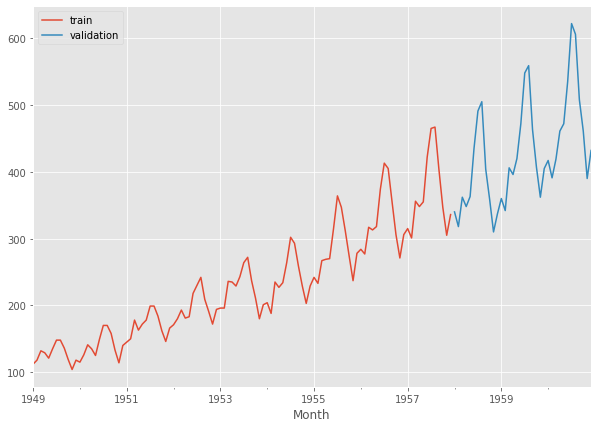

In [12]:
train_data['Thousands of Passengers'].plot(legend=True,label='train')
test_data['Thousands of Passengers'].plot(legend=True,label='validation',figsize=(10,7));

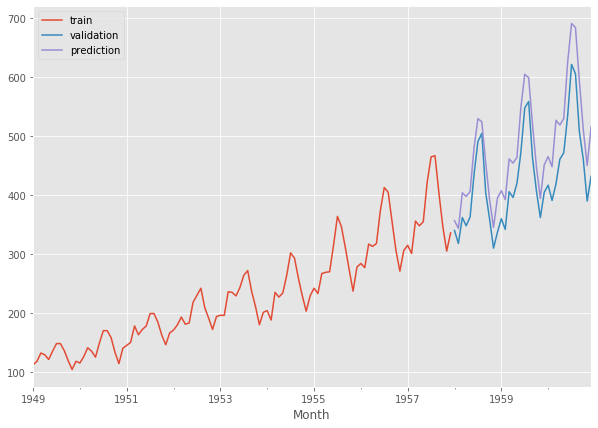

In [13]:
train_data['Thousands of Passengers'].plot(legend=True,label='train')
test_data['Thousands of Passengers'].plot(legend=True,label='validation',figsize=(10,7))
test_predictions.plot(legend=True,label='prediction');

### __Model evaluation__

In [14]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# we have already seen the MAE
MAE = mean_absolute_error(test_data, test_predictions)
MAE

In [ ]:
relative_MAE = MAE/df.mean()
relative_MAE

### __Root mean square error (RMSE)__

The RMSE is a good metric in order to specifically penalise large deviations.

$RMSE = \sqrt{\frac{\sum\limits_{t=1}^n(F_t - A_t)^2}{n}}$ <br/>
<br/>
$F_t$: forecast value <br/>
$A_t$: actual value <br/>
$n$: sample size

In [ ]:
np.sqrt(mean_squared_error(test_data, test_predictions))

### __MAPE__

In [ ]:
(sum(abs((test_data['Thousands of Passengers'] - test_predictions)\
                /test_data['Thousands of Passengers'])))*(100/len(test_data['Thousands of Passengers']))

### __Stationarity__

Stationary data do not feature any trend nor seasonality. Any fluctuations are noise. They are a requirement for some of the classicl methods we will get to know - it is not required for the Holt-Winter method.

In [ ]:
#this dataset contains values with typical characteristics which can occur in a time series.
df2 = pd.read_csv('../data/samples.csv',index_col=0,parse_dates=True)
df2.head()

In [ ]:
plt.style.use('ggplot')
df2['a'].plot(ylim=[0,100],title="stationary data", color='blue').autoscale(axis='x',tight=True);

In [ ]:
plt.style.use('ggplot')
df2['b'].plot(ylim=[0,100],title='non-stationary data', color='blue').autoscale(axis='x',tight=True);

### __Differencing__
Stationarity of non-stationary data can be accomplished through differencing. Differencing calculates the difference between consecutive points.

$y_{t}´ = y_t - y_{t-1}$ <br/>
<br/>
$y_{t}´´ = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$

#### __Using statsmodels__

In [ ]:
from statsmodels.tsa.statespace.tools import diff

#here, we difference our non-stationary dataset
df2['d1'] = diff(df2['b'],k_diff=1)

df2['d1'].plot(title="first difference data", color='blue').autoscale(axis='x',tight=True);

#### __Using pandas__

In [ ]:
#see how differencing decreases your sample size
df2['d1'] = df2['b'] - df2['b'].shift(1) #this command subtracts the past from the present value
df2.head()